In [1]:
# ! pip install --upgrade pip
# ! pip install --upgrade git+https://github.com/oda-hub/oda_api@request-list pandas
# ! pip install linked-data-latex
# ! pip install ruamel.yaml
# ! pip install pymosaic-fits


import oda_api.api
import oda_api.token
import oda_api.plot_tools
import requests
import logging
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np
from ddpaper.draftdata import DraftData
import io

# https://gcn.gsfc.nasa.gov/gcn3/32634.gcn3

In [2]:
# #slightly more verbose
logging.getLogger().setLevel(logging.INFO)
# #all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [3]:
# 120711 https://www.aanda.org/articles/aa/pdf/2014/07/aa20872-12.pdf
# https://www.cosmos.esa.int/web/integral/schedule-information

In [4]:
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np

In [5]:
T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot).mjd - 51544


In [6]:
acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/2000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc

,t,dt,c,ds
0,8317.530324,0.035319,5258.0,45750.851319
1,8317.530325,0.085318,5296.0,45750.901318
2,8317.530326,0.135319,5274.0,45750.951319
3,8317.530326,0.185319,5270.0,45751.001318
4,8317.530327,0.235318,5248.0,45751.051318
...,...,...,...,...
79995,8317.576618,3999.787994,5336.0,49750.603994
79996,8317.576618,3999.837995,5348.0,49750.653995
79997,8317.576619,3999.887997,5396.0,49750.703996
79998,8317.576620,3999.937996,5444.0,49750.753996


In [7]:
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>

In [8]:
from astropy.io import fits

# compton_events = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800290010.000/compton_events.fits.gz")


In [9]:
mce = dict()

for i in range(8):
    mce[i] = pd.read_csv(
        io.StringIO(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/genlc/ISGRIRAW_MCE{i}/{T0_ijd}/2000").text), 
        skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)


np.sum([mce[i].c for i in range(8)], axis=0)

array([9415, 9883, 9448, ..., 9744, 9517, 9607])

In [10]:
T0_ijd

8317.553472222222

In [11]:
scw_dict_prompt = pd.DataFrame(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/{T0_ijd-2000/24/3600}/{T0_ijd+2000/24/3600}?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=200&return_columns=SWID,SW_TYPE,TELAPSE,TSTART,TSTOP").json())


In [12]:
# https://heasarc.gsfc.nasa.gov/docs/integral/ao19-docs-b/AO19_recommended_programme.pdf

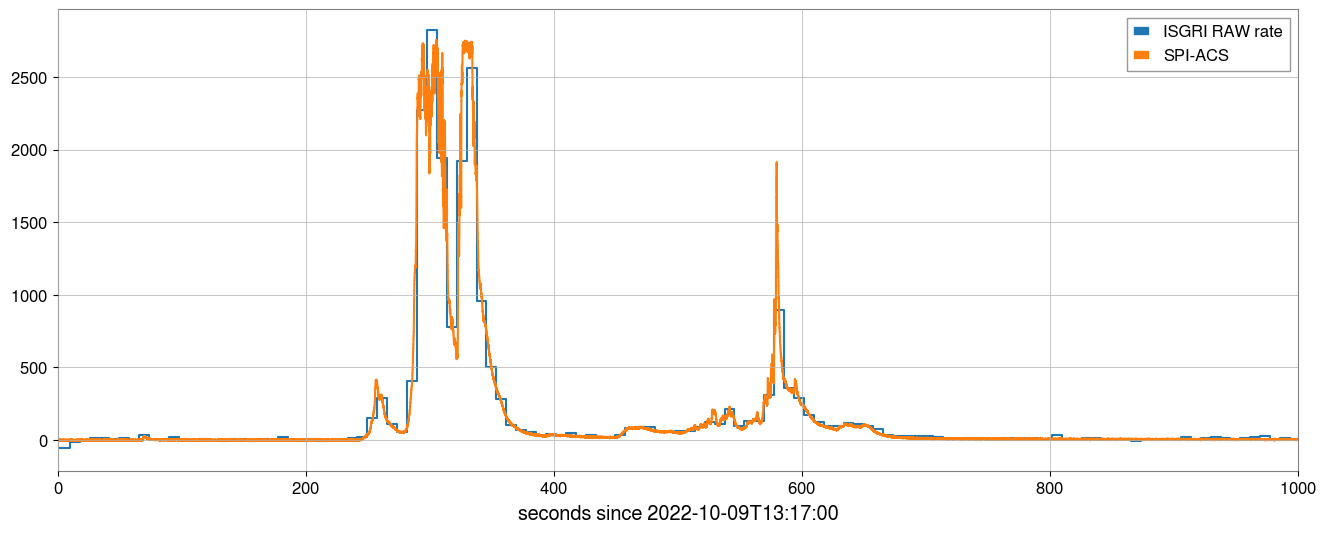

In [13]:
plt.figure(figsize=(16, 6))

try:
    a = isgri_event_file
except:
    isgri_event_file = {}
    compton_event_file = {}

for i, r in scw_dict_prompt.iterrows():
    scwid = r.SWID

    if scwid not in compton_event_file:
        compton_event_file[scwid]  = fits.open(f"/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/{scwid[:4]}/{scwid}.000/compton_events.fits.gz")
        isgri_event_file[scwid]  = fits.open(f"/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/{scwid[:4]}/{scwid}.000/isgri_events.fits.gz")
    else:
        print("already have", scwid)
    

    for C, color, ext in [
                    # (isgri_event_file, 'y', "ISGR-EVTS-ALL"),
                    # (compton_event_file, 'g', "COMP-MULE-ALL"),
                    # (compton_event_file, 'r', 'COMP-SGLE-ALL')
                ]:
        c = C[scwid]

        label=ext + " " + scwid
    

        T = c[ext].data['TIME']

        Ei = 0
        Ep = 0

        try:
            Ei = c[ext].data['ISGRI_ENERGY']            
        except:
            pass
        
        try:
            Ep = c[ext].data['PICSIT_ENERGY']
        except:
            pass

        Ec = Ei + Ep

        ijd2plot = lambda T: (T - T0_ijd)*24*3600

        plt.axvline(
            ijd2plot(r.TSTART), ls="--",
        )
        plt.axvline(
            ijd2plot(r.TSTOP), ls="--",
        )

        plt.text(ijd2plot(r.TSTART), 4000, f"{scwid[6:8]}\n{scwid[10:12]}")
        # plt.text(ijd2plot(r.TSTART), 4000, scwid, rotation=90)


        # plt.axvspan(
        #     ijd2plot(r.TSTART),
        #     ijd2plot(r.TSTOP),
        #     alpha=0.2,
        #     color='red'
        # )
    
        plt.hist(ijd2plot(T), bins=1000, alpha=0.3, color=color, label=label)
        label = None
    
# for i in range(8):
isgri_raw_total_rate = np.sum([mce[i].c for i in range(8)], axis=0 )/20
b = np.mean(isgri_raw_total_rate[(mce[0].t- T0_ijd)*24*3600 < 200])
plt.step((mce[0].t- T0_ijd)*24*3600, isgri_raw_total_rate - b, label="ISGRI RAW rate", where='post')

b = np.mean(acslc.c[(acslc.t- T0_ijd)*24*3600 < 200])
plt.step((acslc.t- T0_ijd)*24*3600, (acslc.c - b)/40, label="SPI-ACS")

plt.legend()
plt.xlabel(f"seconds since {T0_isot}")
plt.xlim([0, 1000])
plt.savefig("figs/compton.pdf")
